In [1]:
%%capture
!wget --no-check-certificate "https://www.crcv.ucf.edu/data/UCF50.rar"
!unrar x UCF50.rar

In [2]:
%%capture 
#!wget --no-check-certificate "https://www.crcv.ucf.edu/data/ucf_sports_actions.zip"
#!wget --no-check-certifacate "http://hi.cs.waseda.ac.jp/~ogata/data/Pose_Dataset.zip"
#!wget --no-check-certifacate "http://hi.cs.waseda.ac.jp/~ogata/data/Video_Dataset.zip"
!unzip "/content/drive/MyDrive/v1.0/InfinityAI_InfiniteRep_squat_v1.0.zip"

In [3]:
# Discard the output of this cell.
%%capture
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot

In [4]:
# Import the required libraries.
%%capture
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [5]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)
class_names= ["PushUps","PullUps","TennisSwing","Basketball","HighJump","SoccerJuggling"]

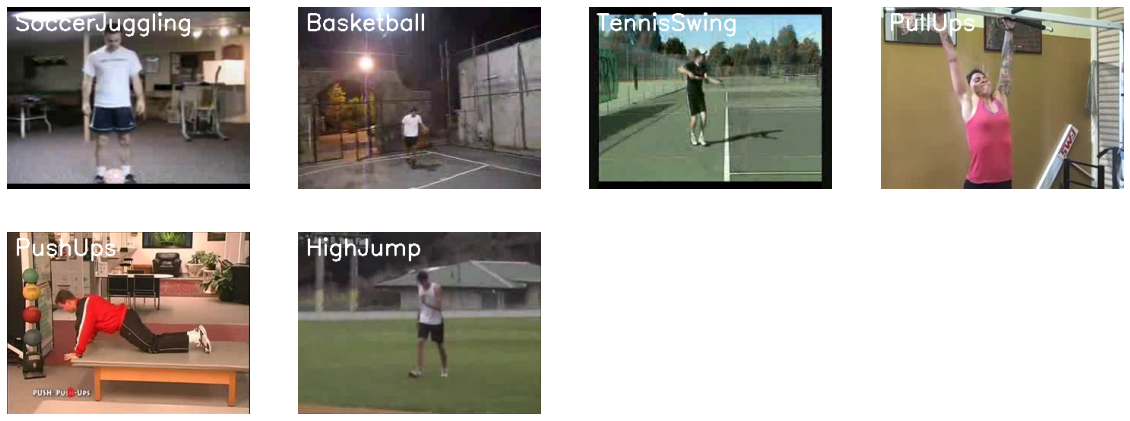

In [6]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('UCF50')
 
random_range = random.sample(range(len(class_names)), 6)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = class_names[random_index]
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [24]:
#height and width to which each video frame will be resized
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"
CLASSES_LIST = class_names

In [26]:
def frames_extraction(video_path):

    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list

In [27]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

In [28]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: PushUps
Extracting Data of Class: PullUps
Extracting Data of Class: TennisSwing
Extracting Data of Class: Basketball
Extracting Data of Class: HighJump
Extracting Data of Class: SoccerJuggling


In [11]:
one_hot_encoded_labels = to_categorical(labels)

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## ConvLSTM Model

In [13]:
def ConvLSTM_Net():

  '''
  increasing filter for each layer
  softmax activation in the last layer
  
  '''
  Model = Sequential([ 
                ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh', recurrent_dropout=0.2,
                          return_sequences=True, input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT, IMAGE_WIDTH, 3)),

                MaxPooling3D(pool_size=(1, 2, 2), padding='same'),
                TimeDistributed(Dropout(0.2)),

                ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', recurrent_dropout=0.2, return_sequences=True),

                MaxPooling3D(pool_size=(1, 2, 2), padding='same'),
                TimeDistributed(Dropout(0.2)),

                ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh',recurrent_dropout=0.2, return_sequences=True),

                MaxPooling3D(pool_size=(1, 2, 2), padding='same'),
                TimeDistributed(Dropout(0.2)),

                ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', recurrent_dropout=0.2, return_sequences=True),

                MaxPooling3D(pool_size=(1, 2, 2), padding='same'),
                #TimeDistributed(Dropout(0.2)),
                Flatten(),

                Dense(len(CLASSES_LIST), activation = "softmax")
               ])

  Model.summary()
    
  return Model       

In [14]:
Model = ConvLSTM_Net()

print("Model created successfully")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

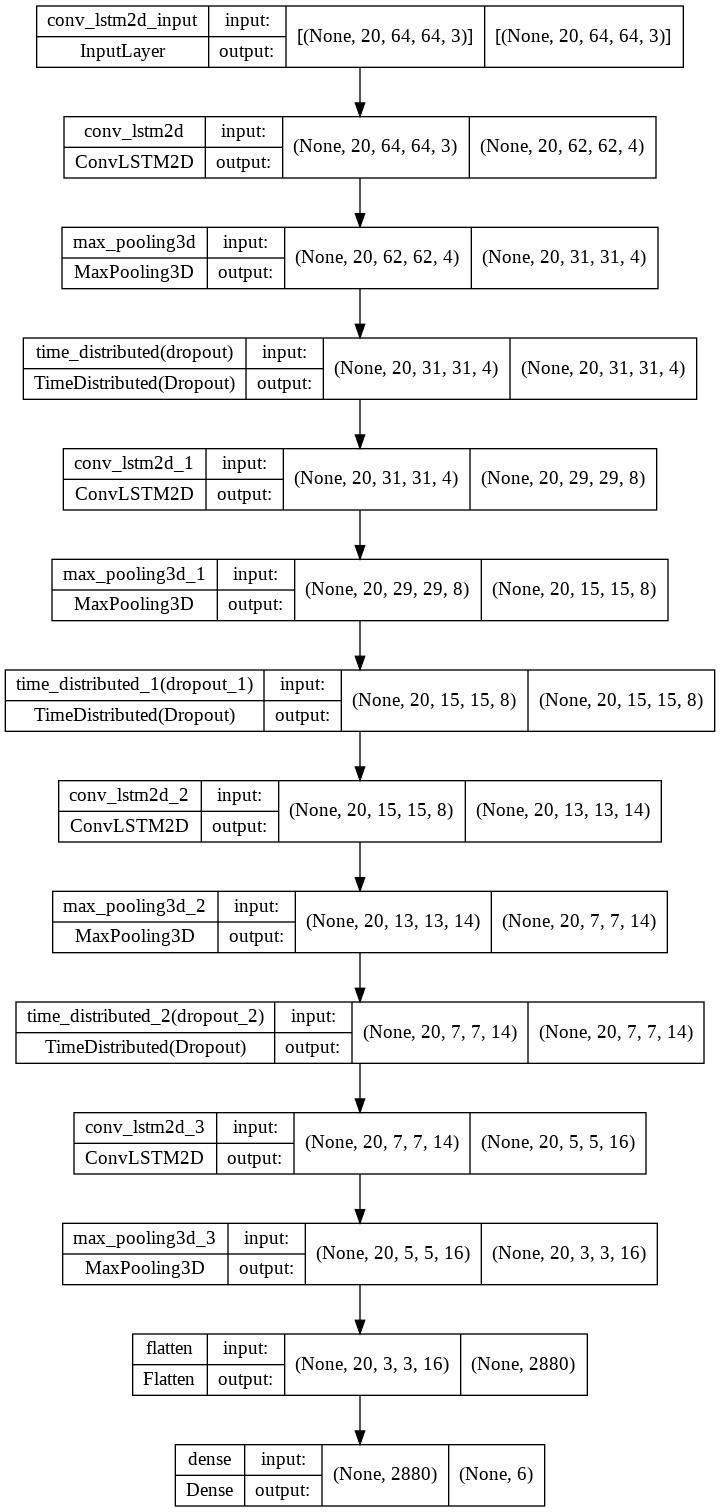

In [15]:
# Plot the structure of the model.
plot_model(Model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Early stopping keeps track of the validation loss, if the loss stops decreasing for several epochs in a row the training stops
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
Model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [ ]:
# Start training the model.
Model_training_history = Model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
121/121 [==============================] - 64s 378ms/step - loss: 1.7544 - accuracy: 0.2087 - val_loss: 1.5745 - val_accuracy: 0.3525
Epoch 2/50
121/121 [==============================] - 48s 393ms/step - loss: 1.5808 - accuracy: 0.3409 - val_loss: 1.5224 - val_accuracy: 0.3852
Epoch 3/50
121/121 [==============================] - 59s 487ms/step - loss: 1.4111 - accuracy: 0.4277 - val_loss: 1.4460 - val_accuracy: 0.5000
Epoch 4/50
121/121 [==============================] - 52s 427ms/step - loss: 1.2270 - accuracy: 0.5517 - val_loss: 1.0926 - val_accuracy: 0.6393
Epoch 5/50
121/121 [==============================] - 52s 427ms/step - loss: 0.9350 - accuracy: 0.6736 - val_loss: 0.9458 - val_accuracy: 0.6721
Epoch 6/50
121/121 [==============================] - 62s 510ms/step - loss: 0.7007 - accuracy: 0.7583 - val_loss: 0.9476 - val_accuracy: 0.7541
Epoch 7/50
121/121 [==============================] - 44s 363ms/step - loss: 0.5397 - accuracy: 0.8037 - val_loss: 0.7456 - val_ac

In [ ]:
# Evaluate the trained model.
model_evaluation_history = Model.evaluate(features_test, labels_test)

7/7 [==============================] - 1s 177ms/step - loss: 0.7495 - accuracy: 0.7340


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))
    plt.legend()

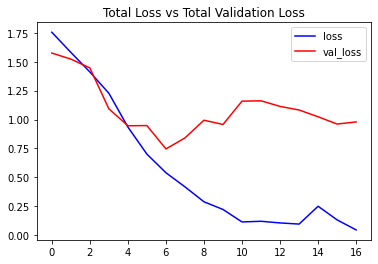

In [ ]:
plot_metric(Model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

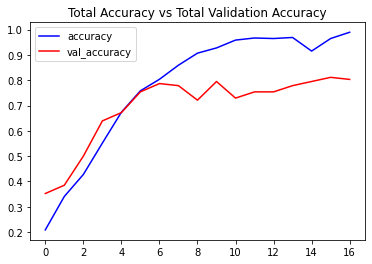

In [ ]:
plot_metric(Model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# LRCN Model  

In [29]:
def LRecConv_Net():
  '''
  increasing filter for each layer
  softmax activation in the last layer
  
  '''
  Model = Sequential([ 
                TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                                          input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)),

                TimeDistributed(MaxPooling2D((4, 4))),
                TimeDistributed(Dropout(0.25)),

                TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')),
                TimeDistributed(MaxPooling2D((4, 4))),
                TimeDistributed(Dropout(0.25)),
                
                TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')),
                TimeDistributed(MaxPooling2D((2, 2))),
                TimeDistributed(Dropout(0.25)),
                
                TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')),
                TimeDistributed(MaxPooling2D((2, 2))),
                #TimeDistributed(Dropout(0.25)))
                                                  
                TimeDistributed(Flatten()),
                                                  
                LSTM(32),
                                                  
                Dense(len(CLASSES_LIST), activation = 'softmax') 
              ])
  Model.summary()

  return Model  

In [30]:
LRCN_model = LRecConv_Net()

print("Model Created Successfully")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

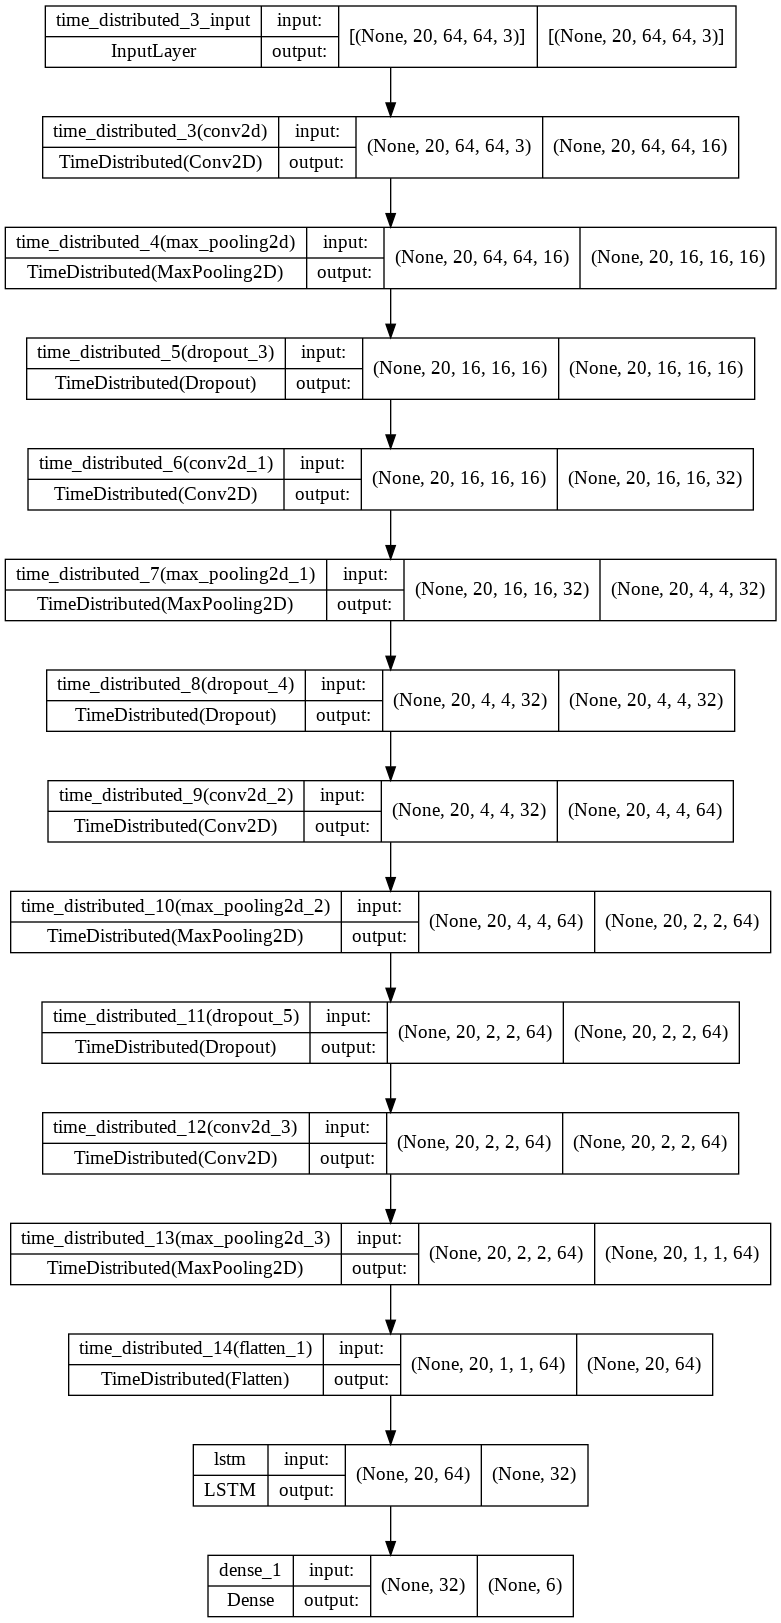

In [31]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create Early Stopping Callback instance
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile model
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# training
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
121/121 [==============================] - 7s 31ms/step - loss: 1.7872 - accuracy: 0.1983 - val_loss: 1.7830 - val_accuracy: 0.2049
Epoch 2/50
121/121 [==============================] - 3s 23ms/step - loss: 1.7575 - accuracy: 0.2252 - val_loss: 1.7457 - val_accuracy: 0.2541
Epoch 3/50
121/121 [==============================] - 3s 23ms/step - loss: 1.6537 - accuracy: 0.2996 - val_loss: 1.6409 - val_accuracy: 0.2623
Epoch 4/50
121/121 [==============================] - 3s 23ms/step - loss: 1.4580 - accuracy: 0.3802 - val_loss: 1.2765 - val_accuracy: 0.5902
Epoch 5/50
121/121 [==============================] - 3s 23ms/step - loss: 1.1953 - accuracy: 0.5310 - val_loss: 1.2410 - val_accuracy: 0.5984
Epoch 6/50
121/121 [==============================] - 3s 23ms/step - loss: 1.0073 - accuracy: 0.6116 - val_loss: 1.2268 - val_accuracy: 0.5820
Epoch 7/50
121/121 [==============================] - 3s 27ms/step - loss: 0.8581 - accuracy: 0.7087 - val_loss: 0.9406 - val_accuracy: 0.6885

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

7/7 [==============================] - 1s 52ms/step - loss: 0.4064 - accuracy: 0.8768


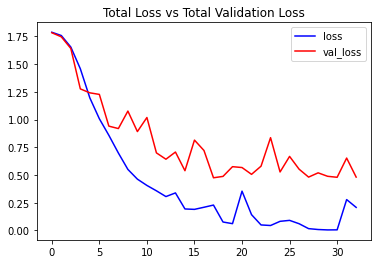

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

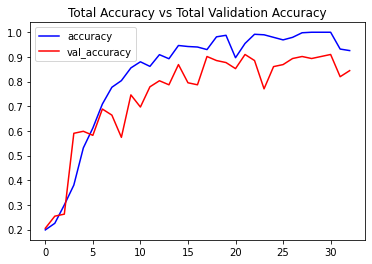

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
model_evaluation_Loss, model_evaluation_accuracy = model_evaluation_history

date_time_pattern = '%Y_%m_%d__%H_%M_%S'
today = dt.datetime.now()
today_string = dt.datetime.strftime(today,date_time_pattern)

model_file_name = f'LRCN_model___Date_Time_{today_string}___Loss_{model_evaluation_Loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

In [20]:
reconstructed_LRCN = load_model("LRCN_model___Date_Time_2022_05_11__17_20_36___Loss_0.4063866138458252___Accuracy_0.8768472671508789.h5")